# Coronavirus (Covid-19) in Israel

In [0]:
import requests
import lxml.html
import re
import datetime
import collections
# %matplotlib --list
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd # to read John Hopkins data 
import io

Load John Hopkins Data

In [2]:
JHUCSSE_url="https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
JHUCSSE_data_raw=requests.get(JHUCSSE_url).content
JHUCSSE_data=pd.read_csv(io.StringIO(JHUCSSE_data_raw.decode('utf-8')))
JHUCSSE_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8


In [3]:
JHUCSSE_data_isr = JHUCSSE_data.loc[JHUCSSE_data['Country/Region']=='Israel'].iloc[:,4:]
JHUCSSE_data_isr.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,3,4,7,10,10,12,15,20,37,43,61,61,75,79,100,126,155,213,218,250,304,427,529,712,883,1071,1238,2369,2693,3035,3619,4247,4695,5358,6092,6857


In [0]:
JHUCSSE_data_isr_dates_str = list(JHUCSSE_data_isr.columns)
JHUCSSE_data_isr_dates = mdates.datestr2num(JHUCSSE_data_isr_dates_str)
JHUCSSE_data_isr_values = JHUCSSE_data_isr.values.tolist()[0]

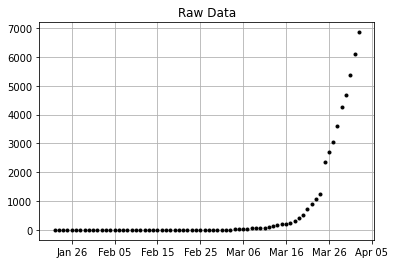

In [5]:
fig, ax = plt.subplots()
ax.plot(JHUCSSE_data_isr_dates, JHUCSSE_data_isr_values,'k.')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.grid(True)
plt.title('Raw Data')
plt.show()

## Prediction

Filter zeroes:

In [0]:
def getCountryData(countryName, population):
    data = JHUCSSE_data.loc[JHUCSSE_data['Country/Region']==countryName].iloc[:,4:]
    if len(data.index)>1:
        data = data.head(1)
    dates_str = list(data.columns)
    dates = mdates.datestr2num(dates_str)
    values = data.values.tolist()[0]
    return np.array(dates), np.array(values)/population*1e6

def expFit(dates1, values1, new_dates):
    idx = np.nonzero(values1)
    dates = np.array(dates1)[idx]
    values = np.array(values1)[idx]
    coeffs, residual =np.polyfit(dates, np.log(values), 1, full=True)[0:2]
    SST = values.size*np.var(values)
    Rsquared = residual[0]/SST
    fitted_fn = np.poly1d(coeffs)
    return np.exp(fitted_fn(new_dates))

## Only Israel

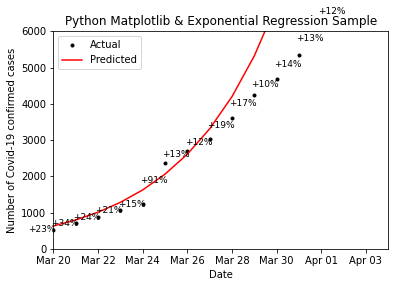

In [7]:
dates_israel, values_israel = getCountryData('Israel',1e6)
new_dates1 = range(dates_israel[0].astype(np.int64), dates_israel[-6].astype(np.int64) + 15)
new_values1 = expFit(dates_israel[:-7], values_israel[:-7], new_dates1)

today_date = mdates.date2num(datetime.date.today())
today_value = 4247

values_nozero = values_israel[values_israel>0]
dates_nozero = dates_israel[values_israel>0]
differentials = 100* (values_nozero[1:]/values_nozero[:-1] - 1)
middates = (dates_nozero[1:] + dates_nozero[:-1]) / 2
midvalues = (values_nozero[1:] + values_nozero[:-1]) / 2

fig, ax = plt.subplots()
ax.plot(dates_israel, values_israel, '.k', label='Actual')
# ax.plot(today_date, today_value, '.b', label='Actual Today')
ax.plot(new_dates1, new_values1, '-r', label='Predicted')
for j in range(len(differentials)-14, len(differentials)):
    ax.text(middates[j], midvalues[j],  '+'+str(int(differentials[j]))+'%' , ha='center', fontsize=9)

ax.legend()
# fig.text(0.20, 0.25, 'S. Londner',
#          fontsize=50, color='gray',
#          rotation=40, rotation_mode='anchor', alpha=0.5)
# plt.grid(True)
plt.title("Python Matplotlib & Exponential Regression Sample")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.ylabel('Number of Covid-19 confirmed cases')
plt.xlabel('Date')
plt.ylim(0,6000)
plt.xlim(today_date-14, today_date+1)
plt.show()